# Data Intelligence Application Project

# Introduction #
The goal of this project is to model a scenario in which a seller exploits advertising tools to attract more and more users to its website, thus increasing the number of possible buyers. The seller needs to learn simultaneously the conversion rate and the number of users the advertising tools can attract. 

The first part is devoted only to a pay-per-click advertising, where we want to maximize the number of users that clicks an advertising banner given a budget constraint. <br> 
In the second part we focus on the pricing application, where a seller needs to identify the best selling price of a good that maximizes the profit without knowing the buyer demand. <br> 
The third and last part aims to combine both the budget allocation and the pricing problems in a scenario in which the two algorithms work at the same time.<br>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import itertools
import pandas as pd
from scipy import stats
from scipy.interpolate import interp1d
from Advertising.environment.Advertising_Config_Manager import *
from Pricing.Pricing_Config_Manager import *

aux_dict = {0:"Young-Familiar", 1: "Adult-Familiar", 2:"Young-NotFamiliar"}
colors = ['r', 'g', 'b']

price_env_id = 0 # item number in the pricing configuration file
adv_env_id = 0   # item number in the advertising configuration file

### Product to sell
We want to place on the market a **new streaming platform of film and series**. <br>
This is a good product to analyze because it fits quite well with the parameters to settle by the experiment: the possibility to diversify the prices for group of users and the cost of the different marketing campaign. Furthermore a subscription cost can be easily modified over time and diversified by classes of users rather than a one-time-buy product. 

### Users characterization
To build a realistic model we have found on internet some data about possible competitors (like *Netflix, Disney+* etc) in order to choose realistic parameters. These data are the average number of users in the last 5 years and the advertising and selling costs. In the end we came up to the following characterization:

* **Features**:
    * *Age={Young, Adult}*: whether the person is under 35 or not
    * *Familiarity={Familiar, Not Familiar}*: whether the person is familiar or not with streaming platforms

* **Classes**: 
    * *Adult - Familiar*: targeted by *Search Advertising* because of their more likelyhood to click on advertising banners on webpages.
    * *Young - Familiar*: targeted by *Display Advertising* because of their common use of consulting websites of their interest.
    * *Young - Not Familiar*: targeted by *Social Advertising* because of their massive use of Social Networks.

The class *Adult - Not Familiar* is not considered because it's the least probable class of users in this kind of services

|       | Familiar | Not Familiar |
|-------|----------|--------------|
| **Young** | x        | x            |
| **Adult** | x        |              |

### Conversion rates
The conversion rate of each class have been modelled in a matrix of probabilities located in a configuration file. <br>
They have been chosen to best represent the willingness of the different types of users to purchase the product at the various price values.

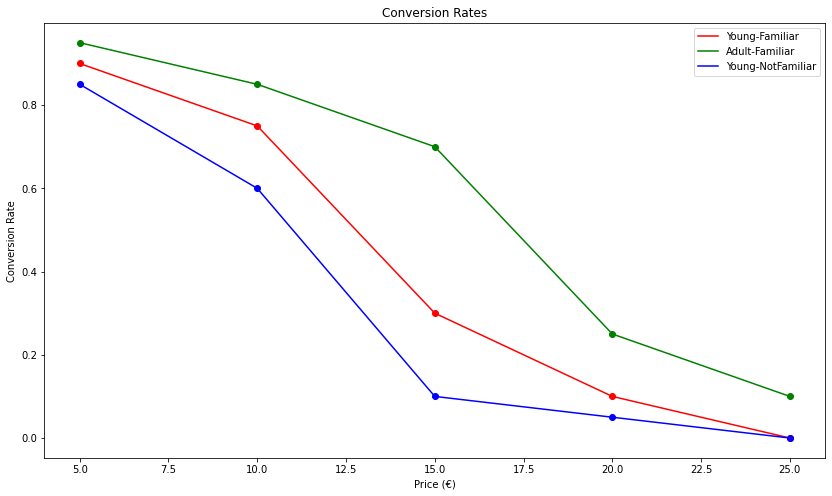

In [42]:
env = Pricing_Config_Manager(price_env_id)

x = env.prices              # list of prices
categories = env.categories # list of categories

plt.figure(figsize=(14,8))
for i in range(len(categories)):
    y = env.probabilities[i]
    smooth = interp1d(x, y, kind='cubic')
    plt.plot(x, smooth(x), color=colors[i], label = aux_dict[i])
    plt.scatter(x, y, color=colors[i])
    plt.title("Conversion Rates")
    plt.xlabel("Price (€)")
    plt.ylabel("Conversion Rate")

plt.legend()
plt.show()

### Abrupt phases
We dediced to consider the whole week and to split it into three phases as follows:
* Morning: 00-12 AM during the week (Mon-Fri)
* Evening: 00-12 PM during the week (Mon-Fri)
* Weekend: all day of Saturday and Sunday

We are supposing that different class of users have different reactions to the three different phases and that within a phase the users will act more or less in the same way. This could be a too simple assumption (at 3 am the action of the users will not be the same as at 10 am) but could actually work in the model because every phases have the same amount of sleep time and awake time.


|       | Mon AM | Mon PM | Tue AM | Tue PM | Wed AM | Wed PM | Thu AM | Thu PM | Fri AM | Fri PM | Sat AM | Sat PM | Sun AM | Sun PM |
|-------------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| **Morning** | x |   | x |   | x |   | x |   | x |   |   |   |   |   |
| **Evening** |   | x |   | x |   | x |   | x |   | x |   |   |   |   |
| **Weekend** |   |   |   |   |   |   |   |   |   |   | x | x | x | x |


### Click functions
For every abrupt phase, the probability distribution over the daily number of clicks changes for every value of budget allocated to each subcampaign.
We have decide to model the click functions as follows and to add a Guassian Noise with 0 mean a variance 2. The click functions are monotonically increasing and are parametrized as follows:
$$click\_function(x|m,s) = m(1-e^{sx})$$
where 
* \\(m\\) is the maximum value that the number of clicks can reach
* \\(s\\) modify the slope of the curve, with \\(0 \lt s\lt1\\).

In [43]:
env = Advertising_Config_Manager(adv_env_id)

budgets = np.linspace(0, 10, num=11)
x = np.linspace(0,max(budgets), num=550)
feature_labels = env.feature_labels
phase_labels = env.phase_labels
phase_weights = env.get_phase_weights()

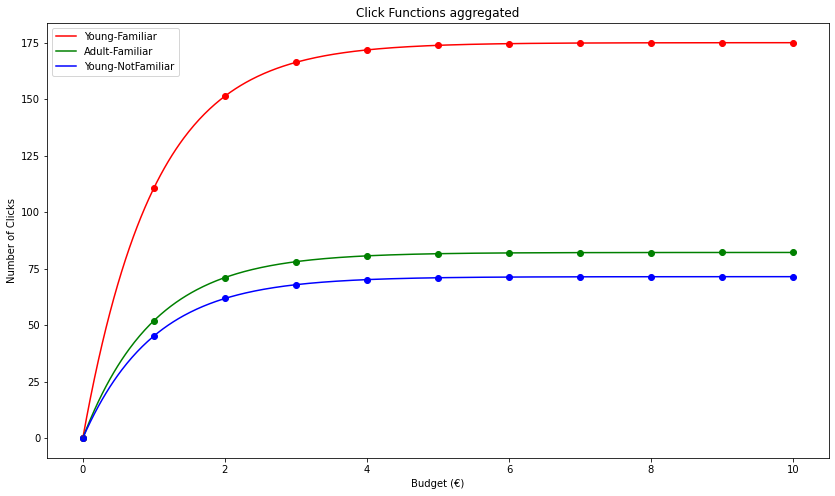

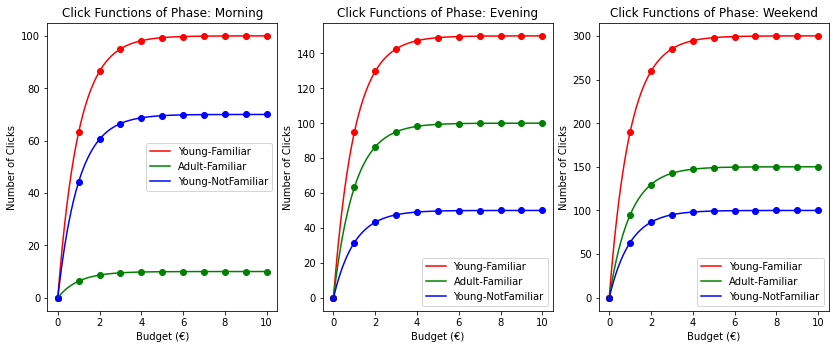

In [44]:
plt.figure(figsize=(14,8))

for i,label in enumerate(feature_labels):
    y = []
    scatter = []
    for j, phase in enumerate(phase_labels):
        y.append(env.click_functions[label][j](x)*phase_weights[j])
        scatter.append(env.click_functions[label][j](budgets)*phase_weights[j])
    aggr_y = sum(y)
    aggr_scatter = sum(scatter)

    plt.plot(x, aggr_y, color=colors[i], label = label)
    plt.scatter(budgets, aggr_scatter, color=colors[i])
    plt.title("Click Functions aggregated")
    plt.xlabel("Budget (€)")
    plt.ylabel("Number of Clicks")
    plt.legend()
    
fig, axs = plt.subplots(1,3, figsize=(14,2))
plt.subplots_adjust(bottom=0.5, top = 2.5)
for i,label in enumerate(feature_labels):
    for j, phase in enumerate(phase_labels):
        y = env.click_functions[label][j](x)
        scatters = env.click_functions[label][j](budgets)
        axs[j].plot(x, y, color=colors[i], label = label)
        axs[j].scatter(budgets, scatters, color=colors[i])
        axs[j].set_title("Click Functions of Phase: " +phase )
        axs[j].set_xlabel("Budget (€)")
        axs[j].set_ylabel("Number of Clicks")
        axs[j].legend()
    

# 1. Advertising campaign

An **advertising campaign** is a series of advertisement messages launched on different media channels to advertise a product/service.
It is characterized by a set of **subcampaigns**, each with a potentially different pair (ad, targeting), and by a **cumulative daily budget**. 

We'll focus on _pay-per-click_ advertising where an advertiser pays only once a user has clicked on his ad. To get an ad impressed, the advertiser take part in an auction, specifying a bid and a daily budget for each subcampaign. The advertiser's goal is to partition the cumulative daily budget over the subcampaigns in order to maximize the number of ad impressed, hence the expected revenue obtained by the advertising campaign. 

_Note:_ we'll implicitly assume that the _bid value_ is automatically computed by the advertising platform once the daily budget is fixed.

## Optimization Problem

### Assumptions

1. The performance of every subcampaign is independent of the performance of the other subcampaigns
2. The values of bid and daily budget are finite

### Formal Model

*  $\max_{x_{j,t}, y_{j,t}} \sum_{j=1}^N v_{j} n_{j}(x_{j,t}, y_{j,t})$
  
  such that: 
  * $ \sum_{j=1}^N y_{j,t} \leq \bar{y}_{t}$, $\forall t \in T$

  * $\underline{x}_{j,t} \leq x_{j,t} \leq \bar{x}_{j,t}, \forall {j \in N}, \forall t \in T$
  
  * $\underline{y}_{j,y} \leq y_{j,t} \leq \bar{y}_{j,t}, \forall j \in N, \forall t \in T$
  
  where

  * $N$ number of subcampaigns
  * $C = \left\{C_{1}, ..., C_{N}\right\}$ advertising campaign
  * $T$ time horizon 
  * $t \in T$ instant of time 
  * $x_{j,t}$ bid of subcampaign *$C_{j}$* at time *t*
  * $y_{j,t}$ daily budget of subcampaign *$C_{j}$* at time *t*
  * $v_{j}$ value per click (impression) of subcampaign *$C_{j}$*
  * $n_{j}(x_{j}, y_{j})$ number of clicks (impressions) of subcampaign   *$C_{j}$* given the values of bid $x_{j}$ and budget $y_{j}$
  * $\bar{y}_{j}$ cumulative daily budget constraint
  * $\left[\underline{x}_{j,t}, \bar{x}_{j,t}\right]$ box constraints for the bid of subcampaign *$C_{j}$* at time *t*
  * $\left[\underline{y}_{j,t}, \bar{y}_{j,t}\right]$ box constraints for the budget of subcampaign *$C_{j}$* at time *t*

### Our Scenario

* Our advertising campaign is composed of 3 subcampaign with a cumulative budget of 10M €. 
* We execute the experiment over a week that is composed of 112 instants of time (8 for each half-day). 
* In the beginning we'll use a unique value per click (i.e. $v_{j}$=1) in order to maximize the total number of clicks, while at the end of the notebook we'll combine the advertising scenario together with the pricing scenario. 
* The budget constraint on each subcampaign will vary from 0 to the cumulative daily budget, in 11 evenly spaced values ($y_{j,t}\in[0,10]$).

In [11]:
advertising_env_id = 0 # id of the campaign to use

max_budget = 10 # maximal amount of budget
n_arms = 11 # number of equispaced values in which the budget is subdivided, starting from 0

sample_factor = 8 # number of samples in an half-day
horizon= 14 * sample_factor

import numpy as np
np.random.seed(1234)
import random
random.seed(1234)

In [12]:
from experiment_2 import *
exp2 = Experiment_2(max_budget, n_arms, advertising_env_id)

### Algorithm: Knapsack

In each instant of time $t \in T$:
1. The algorithm receives in input a table of values $v_{j} n_{j}(x_{j,t}, y_{j,t})$ for each value of bid $x_{j,t}$ and budget $y_{j,t}$
2. For each row, it selects the value of bid that maximize the cell's value
3. Once removed the dependency of the bid values, it constructs a second table where each row includes the expected revenue for different values of budget
4. A third table is constructed by considering a new subcampaign at a time. The value in each cell $(i,j)$ represent the maximum expected revenue obtained by splitting the budget $y_{j}$ between the subcampaign $C_{i}$ and the previous row.
5. The optimal revenue can be found by looking for the maximum value in the last row.
6. The optimal budget partition can be found by proceeding backward from the last row to the initial one.

Let's consider the clairvoyant solution, and let's see how the knapsack algorithm subdivide the cumulative daily budget (here 10) over the 3 subcampaigns, in order to found out the highest number of clicks.

In [13]:
exp2.run_clairvoyant()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,Budget
C0,0.000,110.621,151.316,166.287,171.795,173.821,174.566,174.840,174.941,174.978,174.992,4
C1,0.000,51.924,71.026,78.053,80.638,81.589,81.939,82.068,82.115,82.133,82.139,3
C2,0.000,45.151,61.762,67.872,70.120,70.947,71.252,71.363,71.405,71.420,71.425,3


By giving 4M € to the first campaign, and 3M € to the others, we'll reach the maximul number of 171.795+78.053+67.872 = 317,72 thousand clicks.

## Combinatorial GP bandits
We put together combinatorial bandits with Gaussian Processes.

### Gaussian Processes
If we discrete the click-function curves and we estimate the values of each points, the number of samples required will be too large. By assuming that there is correlation among the points, we can use Gaussian Processes (GPs) to learn these functions. Given a set of samples in the 2D space (budget, clicks) and setting a kernel (usually Gaussian) a GP is able to provide a probability distribution over the results. This probability distribution is crucial in order to assure the convergency of bandit algorithms. The kernel used by a GP has some hyperparameters that can be learned before the actual run, using a set of random samples. In particular we use this approach in the stationary case and we leave the algorithm independently learn these hyperparameters in the non stationary case.


### Combinatorial GP Bandits
In a standard basic bandit problem we can pull a single arm over a set of arms and we observe the reward of the pulled arm. Instead, our arms are correlated and the reward of an arm provides information on the reward of the arms close to it.
A combinatorial GP bandits algorithm allows to pull any set of arms satisfying some combinatorial constraint.


### Our scenario
We model every subcampaign with a **Gaussian Process-Thompson Sampling (GP-TS)** as explained below. Our combinatorial constraint is represented by the **knapsack constraint** that force the cumulative daily budget to be no longer than a given value. Hence, we can at most an arm for each subcampaign such that the sum of them satisfy the knapsack constraints.

**Combinatorial GP-TS algorithm**

 At every time $t \in T$
 1. For every subcampaign *$j \in N$*, for every arm $a \in A$:
 
      $\tilde{n}_{a,j} \leftarrow Sample(\mathbb P(\mu_{a,j}=n_{a,j}))$
      
      
 2. Execute the Knapsack algorithm
 
      $\left\{\hat{y}_{j}\right\}_{j \in N} \leftarrow Knapsack(\left\{(v_{j} \tilde{n}_{a,j}(y), \bar{y}_{j}\right\}_{j \in N})$
 
 
 3. For every subcampaign *$j \in N$*, play arm $\hat{y}_{j}$
 
 
 4. Update the GP according to the observed rewards so far

Let's run an experiment and see how the Guassian Processes perform on each subcampaign.

Performing experiment:  1


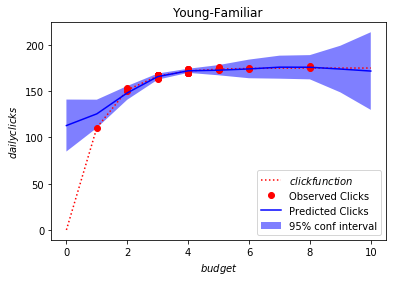

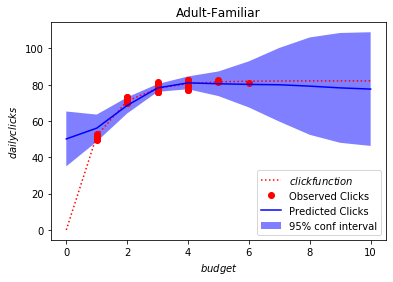

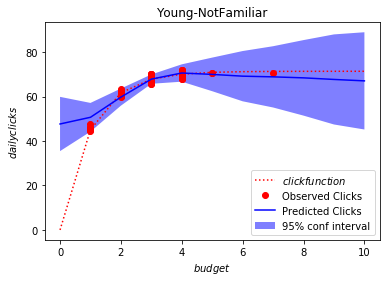

In [55]:
exp2.run(1, horizon, GP_graphs=True)

## Results of the stationary experiment

To obtain a more precise result we perform multiple experiments and we average the estimated click values.
After that we plot the average values of regrets and rewards.

In [56]:
n_experiments= 10 # number of experiment to perform

exp2.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


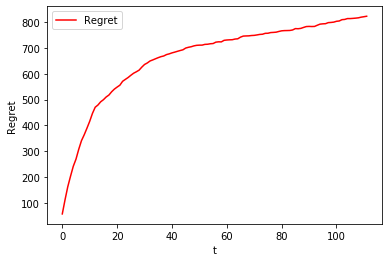

Clairvoyant value: 317.72032055226384


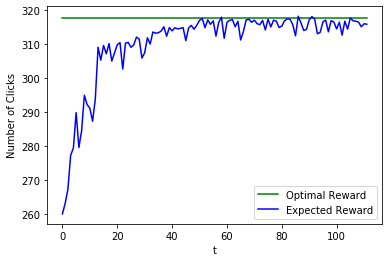

In [57]:
exp2.plot_regret()
print('Clairvoyant value: {}'.format(exp2.opt_super_arm_reward)) #clairvoyant value
exp2.plot_experiment()

## Non-Stationary Experiment

A non-stationary environment has the same configuration of the stationary one but the probability distribution of every arm can change over the time. Time is divided in phases and the reward functions are constant in each phase.

Our environment is divided by three phases (morning, evening and weekend) that compose the eleven _abrupt changes_ spread over the week. 

Standard bandit algorithms fail in non-stationary environments mainly because their bounds monotonically reduce. As a solution, we can use a sliding window to forget old samples. The regret lower bound is larger than in stationary environments since we are using less samples, but the comparison holds only on a the same stationary environment.

Non-stationary environments require permanent exploration otherwise the algorithm will suffer from a constant regret in the worst case. However this permanent exploration makes the regret to be much higher than the stationary case.

### Our Scenario
We use the **GP-Sliding Window-Thomposon Sampling** algorithm in each learner.
We run a non-stationary experiment with the same configuration to easily compare the results with the stationary experiment.


**Combinatorial GP-SW-TS algorithm**

 At every time $t \in T$
 1. For every subcampaign *$j \in N$*, for every arm $a \in A$:
 
      $\tilde{n}_{a,j} \leftarrow Sample(\mathbb P(\mu_{a,j}=n_{a,j}))$
      
      
 2. Execute the Knapsack algorithm
 
      $\left\{\hat{y}_{j}\right\}_{j \in N} \leftarrow Knapsack(\left\{(v_{j} \tilde{n}_{a,j}(y), \bar{y}_{j}\right\}_{j \in N})$
 
 
 3. For every subcampaign *$j \in N$*, play arm $\hat{y}_{j}$
 
 
 4. Update the GP according to the **last observed rewards** (according to the sliding window size)

### Sliding window size setting

Let's execute three experiments with multiple learners having different sliding windows.

In [12]:
from experiment_3 import *
exp3 = Experiment_3(max_budget, n_arms, sample_factor, advertising_env_id, estimate_hyperparam=True)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3


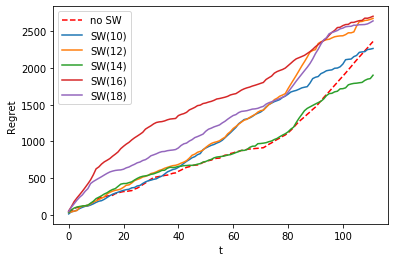

In [13]:
exp3.multiple_run(3, horizon=horizon, window_size=[10,12,14,16,18])
exp3.plot_multiple_regret()

We can observe that the a good sliding window size is 14, so let's set this dimension and re-run the same experiment 10 times to achieve more precise results.

In [14]:
sliding_window = 14
n_experiments = 10
exp3.run(n_experiments, horizon, sliding_window)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


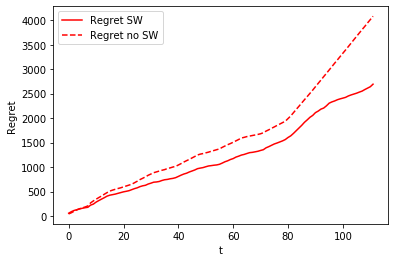

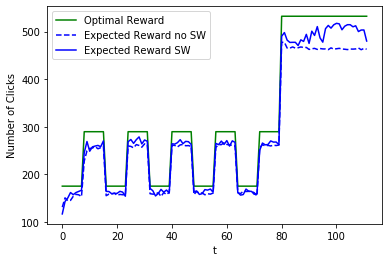

In [15]:
exp3.plot_regret()
exp3.plot_experiment()

The fact that the regret of the algorithm with and whithout are quite similar are probably due the phasing we have decided to use. Indeed as can be seen by the plot of the experiment, the problem is that the last phase has a higher reward than the others, and so the algorithm does not have enough time to learn how to behave to reach the optimal reward in this new setting.

# 2. Pricing Campaign

A Pricing Problem consists on proposing a price to a given customer, receiving a positive outcome or a negative outcome.
We want to estimate the Demand Curve of the Customers based on the different prices that are offered to them.
Because the set of possible prices is continuos, we discretize it with integer values, choosing only five of them.
We have chosen the prices for our product as 5, 10 ,15, 20, 25 euros.

We use a Thompson Sampling Algorithm to choose the price to propose to each client.
TS will learn a Beta Distributions for each price, adjusting the relative parameters $\alpha_{price}$ and $\beta_{price}$ with the outcomes of the proposed price.

In [1]:
from experiment4_5 import *
n_experiments = 10
horizon = 5000 ## how many people are used to perform each experiment
pricing_env_id = 0

### Thompson Sampling
1. At every time $t$, for every arm $a$

     $\tilde{\theta}_{a} \leftarrow Sample(\mathbb P(\mu_{a}=\theta_{a}))$ (Beta Distribution)


2. At every $t$ play $a$ such that:
 
     $a_{t} \leftarrow  \arg\max_{a \in A} \left\{\tilde{\theta}_{a} price_{a} \right\}$
 

3. Update the Beta distribution of arm as:

    $(\alpha_{a_{t}}, \beta_{a_{t}}) ← (\alpha_{a_{t}}, \beta_{a_{t}}) + (x_{a_{t},t}, 1 − x_{a_{t},t})$


### No context generation

Performing experiment: 1
[4.5        7.33333333 5.5        2.66666667 0.83333333]


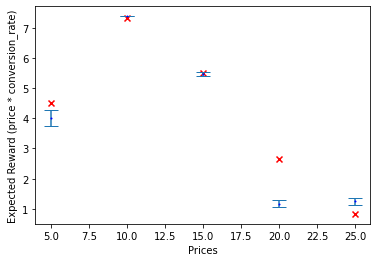

In [2]:
exp4ex = Experiment_4_5(pricing_env_id)
exp4ex.run_experiment(1, horizon,beta_graph=True)

In [3]:
exp4 = Experiment_4_5(pricing_env_id)
exp4.run_experiment(n_experiments, horizon) # no week paseed -> No context generation

Performing experiment: 1
Performing experiment: 2
Performing experiment: 3
Performing experiment: 4
Performing experiment: 5
Performing experiment: 6
Performing experiment: 7
Performing experiment: 8
Performing experiment: 9
Performing experiment: 10


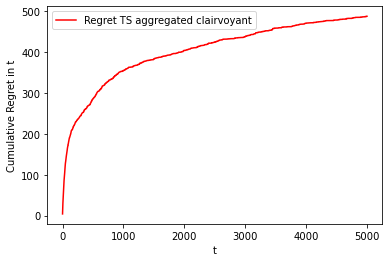

In [4]:
exp4.plot_regret_aggregated()

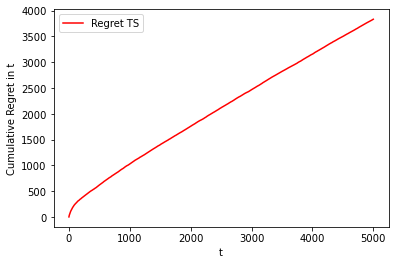

In [5]:
exp4.plot_regret()

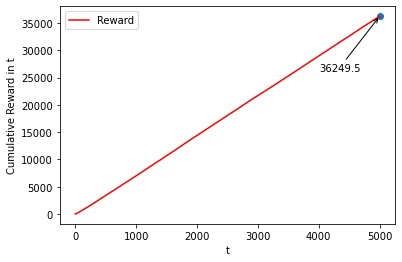

In [6]:
exp4.plot_reward()

Note that the first regret is computed using as clayrvoiant an algorithm that average the probabilities of the three classes. <br>
The regret that must be compared with the Context Generation case is the second one.

### Context Generation - Disaggregate Demand Curve

After a certain number of customers analyzed by the Learning Algorithm, the space of features is split into different contexts, if it is respected the split condition.

### Split Condition
Split when the following condition holds for the context:

$p_{c_{1}}\mu_{a^{*}_{c1},c1} + p_{c_{2}}\mu_{a^{*}_{c2},c2} \geq \mu_{a^{*}_{c0},c0}$


In [7]:
exp5 = Experiment_4_5(pricing_env_id)

In [8]:
exp5.run_experiment(n_experiments, horizon, week = 1200, context_graph=True) ## week says how many people arrives each week, at the end end of a week there is a context split

Performing experiment: 1


Performing experiment: 2


Performing experiment: 3


Performing experiment: 4


Performing experiment: 5


Performing experiment: 6


Performing experiment: 7


Performing experiment: 8


Performing experiment: 9


Performing experiment: 10


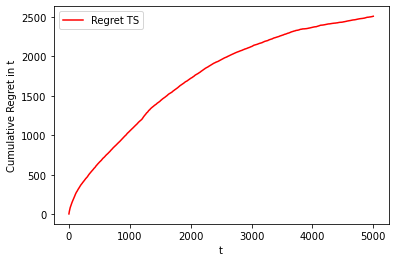

In [9]:
exp5.plot_regret()

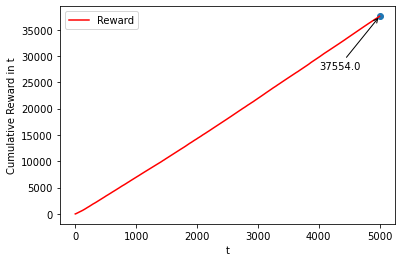

In [10]:
exp5.plot_reward()

We can clearly see that, using the Thompson Sampling combined with the Context Generation, the Regret stabilyzes quickly at a maximum, without increase. 
Indeed, the learning algorithm has learnt to offer the optimal candidates for each context. 
In some experiments it has learned to split the classes into three different context, or only two. 
This is caused by the random arrival of customers in each experiment.

# 3. Combining Advertising and Pricing campaign

In this setting we combine the algorithms of **Advertising** and **Pricing**, trying to decide the allocation of budget in the different subcampaigns. Here we use the **product of number of clicks and expected rewards** as _value-per-click_ in the knapsack optimization algorithm.

The second term is computed by the pricing algorithm at each round of the budget allocation. It considers as users the number of people (clicks) given by the expected values of the learners of the advertising algorithm. 

The two problems can be decompose since we assume that the classes of users in the pricing algorithm are known and each subcampaign targets a single class of users. 

### Combined Algorithm

 At every time $t \in T$
 1. For every subcampaign *$j \in N$*, for every arm $a \in A$:
 
      $\tilde{n}_{a,j} \leftarrow Sample(\mathbb P(\mu_{a,j}=n_{a,j}))$
      
 2. For every expected value $v_{p,j}$ for every price $p$, for every class of users $j$
      
      $v_{j} \leftarrow \max_{p}(v_{p,j})$
      
 3. Execute the Knapsack algorithm:
 
      $\left\{\hat{y}_{j}\right\}_{j \in N} \leftarrow Knapsack(\left\{(v_{j} * \tilde{n}_{a,j}(y), \bar{y}_{j}\right\}_{j \in N})$
 
 
 4. For every subcampaign *$j \in N$*, play arm $\hat{y}_{j}$ and save the rewards of the current $t$ $\left\{y_{j,t}\right\}_{j \in N}$
 
 
 5. Update the GP according to the observed rewards so far
 
 6. Execute the Pricing algorithm with $\left\{y_{j,t}\right\}_{j \in N}$ numbers of users for each class $j \in N$ and update the expected values $v_{p,j}$ to be used in the next round

In [1]:
from experiment_6 import *
advertising_env_id = 0 # id of the advertising campaign to use
pricing_env_id = 0 # id of the pricing campaign to use

max_budget = 10 # maximal amount of budget
n_arms = 11 # number of equispaced values in which the budget is subdivided, starting from 0

sample_factor = 8 # number of samples in an half-day
horizon= 14 * sample_factor

In [2]:
n_experiments = 10
exp6 = Experiment_6(max_budget, n_arms, pricing_env_id, advertising_env_id)
exp6.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


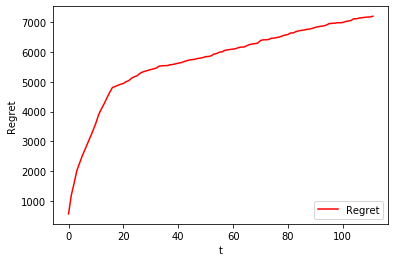

In [3]:
exp6.plot_regret()

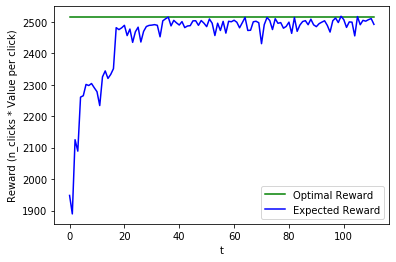

In [4]:
exp6.plot_experiment()

## Alternative Scenario
In this scenario, the algorithm is as before but **the same price is assigned to any class of users** instead of selecting the best price according to the best expected reward for every class of users.

In the implementation, we **repeat the _knapsack-like optimization_ as many times as we have values of price**, using the expected rewards of the corresponding price for each class of users as _value-per-click_ in each _knapsack_ input table. We choose the value of price that maximize the sum of the output values of the _knapsack_ (that correspond to different values of budget).

This alternative algorithm aims to show whether the pricing algorithm is useful if combined with the budget optimization or similar results can be obtained by just setting the very same price to all the class of users.

### Alternative Combined Algorithm
 
 At every time $t \in T$
 1. For every subcampaign *$j \in N$*, for every arm $a \in A$:
 
      $\tilde{n}_{a,j} \leftarrow Sample(\mathbb P(\mu_{a,j}=n_{a,j}))$
      
 2. For every value of price $p$ execute the Knapsack algorithm with a diffrent table, whose element are $v_{p,j} * \tilde{n}_{a,j}$
 
      $\left\{\hat{y}_{p,j}\right\}_{p \in P, j \in N} \leftarrow Knapsack(\left\{(v_{p,j} * \tilde{n}_{a,j}(y), \bar{y}_{j}\right\}_{p \in P,j \in N})$
 
 3. Select the knapsack result corresponding to a value of price $p*$ such that:
 
 $\left\{\hat{y}_{p^*,j}\right\}_{j \in N} \leftarrow  \arg\max_{p} \sum_a \left\{\hat{y}_{p,j}\right\}_{p \in P, j \in N}$
 
 4. For every subcampaign *$j \in N$*, play arm $\hat{y}_{p*,j}$ and save the rewards of the current $t$ $\left\{y_{j,t}\right\}_{j \in N}$
 
 
 5. Update the GP according to the observed rewards so far
 
 6. Execute the Pricing algorithm with $\left\{y_{j,t}\right\}_{j \in N}$ numbers of users for each class $j \in N$ and update the expected values $v_{p,j}$ to be used in the next round

#### Different clayrvoyant from experiment 6
In this first run, we try to use a different clairvoyant that runs the very same algorithm of part 7, but knowing of course the real environment. It is forced to give the same price to all the contexts.

In [5]:
from experiment_7 import *
n_experiments = 10
exp7 = Experiment_7(max_budget, n_arms, pricing_env_id, advertising_env_id)
exp7.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


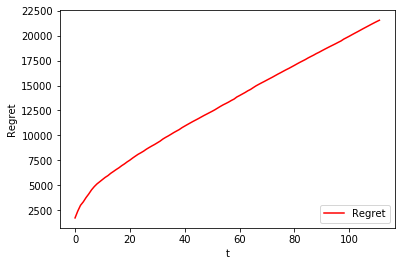

In [6]:
exp7.plot_regret()

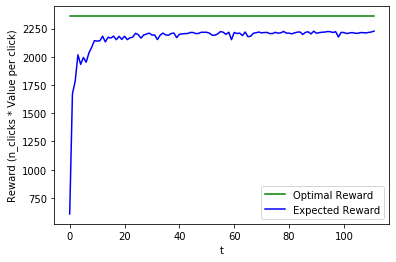

In [7]:
exp7.plot_experiment()

#### Same Clairvoyant of experiment 7
Here instead we use a the same clairvoyant of part 6, that gives the different prices to different context (if it is the case)

In [8]:
exp7 = Experiment_7(max_budget, n_arms, pricing_env_id, advertising_env_id,alt_clairvoyant=True)
exp7.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


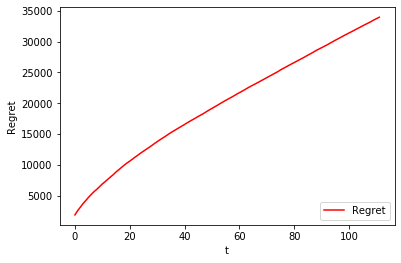

In [9]:
exp7.plot_regret()

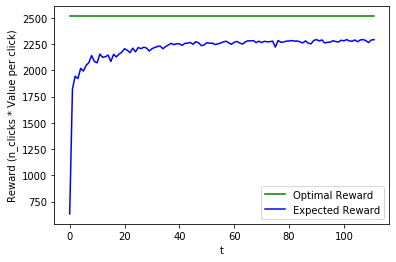

In [10]:
exp7.plot_experiment()

The results show that, given a setting of conversion rates in which a **single vlaue of price corresponds to the best expected reward** (price * conversion rate) **for all class of users**, the two algorithm, respectively the original one and the alternative one, perform the same.<br> Otherwise, if it does not exist such a situation, and this is the case showed, the alternative algorithm perform worst and also the optimal value reachable is lower than the original one (first case, using a clairvoyant forced to give same price to all contexts).